# With Synthetic Data

In [1]:
import os
PATH = os.getenv("HOME")
os.chdir(f"{PATH}/watttime-python-client-aer-algo")

import pandas as pd
import evaluation.eval_framework as evu
from datetime import datetime

import seaborn as sns
import evaluation.metrics as m

username = os.getenv("WATTTIME_USER")
password = os.getenv("WATTTIME_PASSWORD")


In [2]:
import random
import math
from watttime import WattTimeForecast, WattTimeHistorical
import data.s3 as s3u

In [3]:
s3 = s3u.s3_utils()

## Analysis Details
- 2024 dates only
- 1000 users
- sanity check on 9 current regions + 9 randomly selected other regions
- set of requery increments to test: none, 5,15,60,180
- charging windows of lengths 3,6,12 hours
- Charge needed at least 45 minutes (25% of smallest window)

### Regions

In [4]:
original_regions = [
    "SPP_TX",
    "ERCOT_EASTTX",
    "FPL",
    "SOCO",
    "PJM_CHICAGO",
    "LDWP",
    "PJM_DC",
    "NYISO_NYC",
]

#from evaluation.config import MOER_REGION_LIST
#random_regions = random.sample([elem for elem in MOER_REGION_LIST if elem not in regions], 9)

random_regions = [
    'PACE',
    'PNM',
    'MISO_INDIANAPOLIS',
    'WALC',
    'SPP_FORTPECK',
    'SPP_KANSAS',
    'AECI',
    'BANC',
    'PJM_SOUTHWEST_OH'
]

regions = original_regions+random_regions

In [5]:
df_req = s3.load_csvdataframe("requery_data/20241203_1k_synth_users_96_days.csv")

<Axes: ylabel='Frequency'>

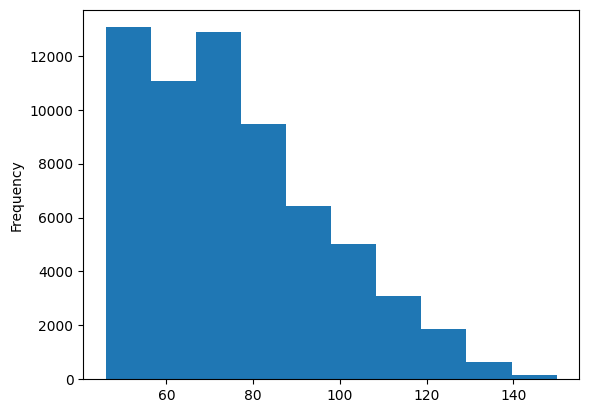

In [6]:
df_req.usage_time_required_minutes.plot(kind='hist')

In [7]:
forecast_generator = WattTimeForecast(username, password)
historical_generator = WattTimeHistorical(username, password)

### Single test

In [8]:
#import importlib
#importlib.reload(evu)

In [9]:
def sanitize_time_needed(x,y):
    return int(math.ceil(min(x, y) / 300.0) * 5)

def sanitize_total_intervals(x):
    return math.ceil(x)

In [10]:
optimization_method = "simple"
requery_intervals = [5,15,60,180]
region = "PJM_SOUTHWEST_OH"

full_forecast = s3.load_parquetdataframe(f"complete_2024_forecast_history/{region}.parquet")
full_history = s3.load_parquetdataframe(f"complete_2024_actual_history/{region}.parquet")

In [11]:
# Sanitize input data
df_req["sanitize_intervals_plugged_in"] = df_req.apply(lambda x: sanitize_total_intervals(x.total_intervals_plugged_in), axis=1)
df_req["sanitize_time_needed"] = df_req.apply(lambda x: sanitize_time_needed(x.total_seconds_to_95, x.length_of_session_in_seconds), axis=1)

In [12]:
synth_data = df_req.sample(10)

In [15]:
synth_data.session_start_time = pd.to_datetime(synth_data.session_start_time)
synth_data.session_end_time = pd.to_datetime(synth_data.session_end_time)

In [16]:
synth_data.head(1).T

,17391
index,57
distinct_dates,2024-07-20
user_type,r29.027500000000003_tc85_avglc25758_sdlc7236_c...
session_start_time,2024-07-20 01:42:16
session_end_time,2024-07-20 07:42:16
initial_charge,0.553131
total_seconds_to_95,4183.682174
full_charge_time,2024-07-20 02:51:59.682174352
length_of_session_in_seconds,21600.0
charged_kWh_actual,33.733843


In [17]:
time_zone = evu.get_timezone_from_dict(region)                    
start_time = pd.Timestamp(evu.convert_to_utc(synth_data.iloc[0]['session_start_time'].round('5min') , time_zone))
end_time = pd.Timestamp(evu.convert_to_utc(synth_data.iloc[0]['session_end_time'].round('5min'), time_zone))
time_needed = 50
usage_power_kw = 36.1675

In [19]:
print(start_time, end_time)

2024-07-20 05:40:00+00:00 2024-07-20 11:40:00+00:00


In [20]:
schedules = evu.full_requery_sim(
    region=region,
    full_forecast=full_forecast,
    full_history=full_history,
    increments=requery_intervals,
    start_time=start_time,
    end_time=end_time,
    usage_power_kw=usage_power_kw,
    time_needed=time_needed,
    method="auto",
    charge_per_interval=None
)

== Simple fit! ==
== Baseline fit! ==
== Simple fit! ==
74
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==


/home/jennifer.badolato/watttime-python-client-aer-algo/watttime/api.py:887: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df["usage"] = usage_list
/home/jennifer.badolato/watttime-python-client-aer-algo/watttime/api.py:887: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df["usage"] = usage_list
/home/jennifer.badolato/watttime-python-client-aer-algo/watttime/api.py:887: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_in

== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==


/home/jennifer.badolato/watttime-python-client-aer-algo/watttime/api.py:887: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df["usage"] = usage_list
/home/jennifer.badolato/watttime-python-client-aer-algo/watttime/api.py:887: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df["usage"] = usage_list
/home/jennifer.badolato/watttime-python-client-aer-algo/watttime/api.py:887: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_in

== Simple fit! ==
== Simple fit! ==
== Sophisticated fit! ==
== Sophisticated fit! ==
== Sophisticated fit! ==
== Sophisticated fit! ==
== Sophisticated fit! ==
== Sophisticated fit! ==
== Sophisticated fit! ==
== Sophisticated fit! ==
== Sophisticated fit! ==
== Sophisticated fit! ==


/home/jennifer.badolato/watttime-python-client-aer-algo/watttime/api.py:887: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df["usage"] = usage_list
/home/jennifer.badolato/watttime-python-client-aer-algo/watttime/api.py:887: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df["usage"] = usage_list
/home/jennifer.badolato/.local/lib/python3.9/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home

== Sophisticated fit! ==
== Sophisticated fit! ==
== Sophisticated fit! ==
== Sophisticated fit! ==
== Sophisticated fit! ==
== Sophisticated fit! ==
== Sophisticated fit! ==
== Sophisticated fit! ==
== Sophisticated fit! ==


/home/jennifer.badolato/.local/lib/python3.9/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/jennifer.badolato/.local/lib/python3.9/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/jennifer.badolato/.local/lib/python3.9/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/jennifer.badolato/watttime-python-client-aer-algo/watttime/api.py:887: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df["usage"] = usage_list
/home/jennifer.badolato/.loc

== Sophisticated fit! ==
== Sophisticated fit! ==
== Sophisticated fit! ==
== Sophisticated fit! ==
== Sophisticated fit! ==
== Sophisticated fit! ==
== Sophisticated fit! ==
== Sophisticated fit! ==
== Sophisticated fit! ==


/home/jennifer.badolato/.local/lib/python3.9/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/jennifer.badolato/.local/lib/python3.9/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/jennifer.badolato/.local/lib/python3.9/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/jennifer.badolato/watttime-python-client-aer-algo/watttime/api.py:887: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df["usage"] = usage_list
/home/jennifer.badolato/.loc

== Sophisticated fit! ==
== Sophisticated fit! ==
== Sophisticated fit! ==
== Sophisticated fit! ==
== Sophisticated fit! ==
== Sophisticated fit! ==
== Sophisticated fit! ==
== Sophisticated fit! ==
== Sophisticated fit! ==


/home/jennifer.badolato/.local/lib/python3.9/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/jennifer.badolato/.local/lib/python3.9/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/jennifer.badolato/.local/lib/python3.9/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/jennifer.badolato/watttime-python-client-aer-algo/watttime/api.py:887: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df["usage"] = usage_list
/home/jennifer.badolato/.loc

== Sophisticated fit! ==
== Sophisticated fit! ==
== Sophisticated fit! ==
== Sophisticated fit! ==
== Sophisticated fit! ==
25
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Sophisticated fit! ==
== Sophisticated fit! ==
== Sophisticated fit! ==
== Sophisticated fit! ==
== Sophisticated fit! ==
== Sophisticated fit! ==
== Sophisticated fit! ==
== Sophisticated fit! ==
== Sophisticated fit! ==
== Sophisticated fit! ==
== Sophisticated fit! ==


/home/jennifer.badolato/watttime-python-client-aer-algo/watttime/api.py:887: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df["usage"] = usage_list
/home/jennifer.badolato/watttime-python-client-aer-algo/watttime/api.py:887: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df["usage"] = usage_list
/home/jennifer.badolato/watttime-python-client-aer-algo/watttime/api.py:887: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_in

7
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Sophisticated fit! ==
== Sophisticated fit! ==
== Sophisticated fit! ==
3
== Simple fit! ==
== Simple fit! ==
== Sophisticated fit! ==
What is going on


/home/jennifer.badolato/watttime-python-client-aer-algo/watttime/api.py:887: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df["usage"] = usage_list
/home/jennifer.badolato/watttime-python-client-aer-algo/watttime/api.py:887: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df["usage"] = usage_list
/home/jennifer.badolato/watttime-python-client-aer-algo/watttime/api.py:887: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_in

In [21]:
evu.get_schedule_and_cost_api_requerying(
    region,
    usage_power_kw,
    time_needed,
    start_time,
    end_time,
    optimization_method="auto",
    moer_list = None,
    charge_per_interval = None,
    requery_interval_minutes = 60


)

== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==


/home/jennifer.badolato/.local/lib/python3.9/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/jennifer.badolato/.local/lib/python3.9/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/jennifer.badolato/.local/lib/python3.9/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


== Sophisticated fit! ==
== Sophisticated fit! ==


/home/jennifer.badolato/.local/lib/python3.9/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/jennifer.badolato/.local/lib/python3.9/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/jennifer.badolato/.local/lib/python3.9/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


,pred_moer,usage,emissions_co2e_lb,energy_usage_mwh
point_time,,,,
2024-07-20 05:40:00+00:00,1211.9,0.0,0.0,0.0
2024-07-20 05:45:00+00:00,1211.9,0.0,0.0,0.0
2024-07-20 05:50:00+00:00,1211.4,0.0,0.0,0.0
2024-07-20 05:55:00+00:00,1210.4,0.0,0.0,0.0
2024-07-20 06:00:00+00:00,1210.9,0.0,0.0,0.0
...,...,...,...,...
2024-07-20 11:15:00+00:00,1152.8,0.0,0.0,0.0
2024-07-20 11:20:00+00:00,1156.1,0.0,0.0,0.0
2024-07-20 11:25:00+00:00,1163.9,0.0,0.0,0.0
